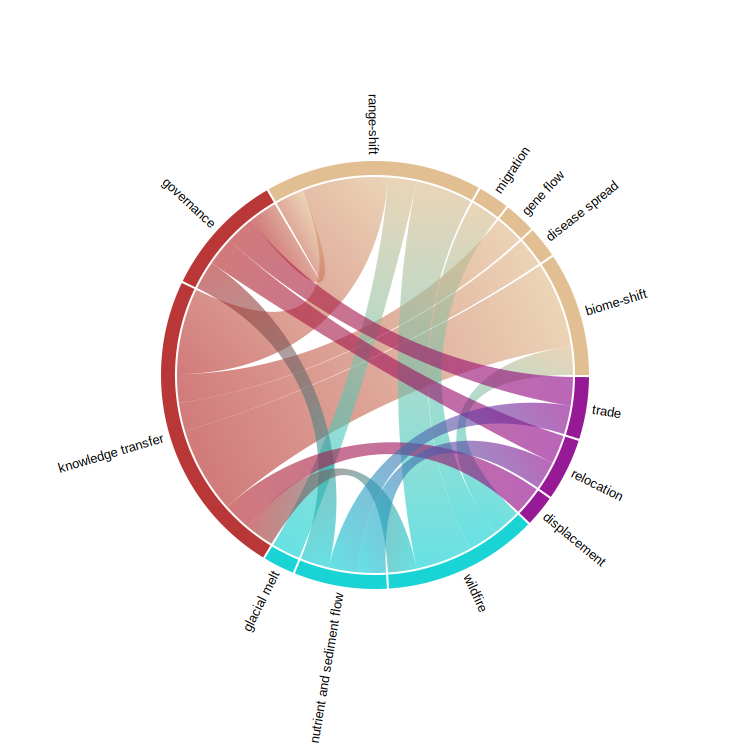

In [1]:
import pandas as pd
import numpy as np
import openchord as ocd
import seaborn as sns

# Load data
file_path = "path"
df = pd.read_csv(file_path)

# Clean and standardize flow type column
df_filtered = df[['DOI', 'X2.1.Flow.Type', 'X2.2.Subtype']].copy()
df_filtered['2.1.Flow.Type'] = df_filtered['X2.1.Flow.Type'].astype(str).str.lower().str.strip()
df_filtered['2.2.Subtype'] = df_filtered['X2.2.Subtype'].astype(str).str.lower().str.strip()

# Combine flow type and subtype into one string
df_filtered['Flow-Subtype'] = df_filtered['2.1.Flow.Type'] + " - " + df_filtered['2.2.Subtype']

# Pull out just the subtype (the part after the dash)
df_filtered['Subtype Only'] = df_filtered['Flow-Subtype'].apply(lambda x: x.split(" - ", 1)[1] if " - " in x else x)

# Sort
flow_type_order = ['biotic', 'sociocultural', 'physical', 'human movement', 'trade']
df_filtered['Flow Order'] = df_filtered['2.1.Flow.Type'].map(lambda x: flow_type_order.index(x) if x in flow_type_order else len(flow_type_order))
df_filtered = df_filtered.sort_values(by=['Flow Order', 'Subtype Only'])

# Build cross-type connections within each paper
connections = []
for doi, group in df_filtered.groupby('DOI'):
    # Group subtypes by their main flow type for each paper
    subtype_by_main_flow = group.groupby('2.1.Flow.Type')['Subtype Only'].unique().to_dict()
    main_flows = list(subtype_by_main_flow.keys())
    if len(main_flows) < 2:
        continue
    # Connect every subtype from one main flow type with every subtype from another
    for i in range(len(main_flows)):
        for j in range(i + 1, len(main_flows)):
            for subtype_i in subtype_by_main_flow[main_flows[i]]:
                for subtype_j in subtype_by_main_flow[main_flows[j]]:
                    connections.append((subtype_i, subtype_j))

# Count co-occurrences
connections_df = pd.DataFrame(connections, columns=['Subtype1', 'Subtype2'])
connections_df = connections_df.groupby(['Subtype1', 'Subtype2']).size().reset_index(name='Weight')

# Filter and sort
active_subtypes = set(connections_df['Subtype1']).union(set(connections_df['Subtype2']))
df_filtered = df_filtered[df_filtered['Subtype Only'].isin(active_subtypes)]
sorted_subtypes = sorted(active_subtypes, key=lambda x: (df_filtered[df_filtered['Subtype Only'] == x]['Flow Order'].iloc[0], x))

# Build an adjacency matrix for the chord diagram
subtype_index = {subtype: idx for idx, subtype in enumerate(sorted_subtypes)}
matrix_size = len(sorted_subtypes)
adj_matrix = np.zeros((matrix_size, matrix_size))

# Fill in the matrix with co-occurrence weights
for _, row in connections_df.iterrows():
    i, j = subtype_index[row['Subtype1']], subtype_index[row['Subtype2']]
    adj_matrix[i, j] += row['Weight']
    adj_matrix[j, i] += row['Weight']  # Ensure symmetry

# custom flow colors
flow_type_colors = {
    'biotic': "#DEB887",       
    'sociocultural': "#B22222",
    'physical': "#00CED1",
    'human movement': "#8B008B",
    'trade': "#ffed6f"
}

subtype_colors = []
for subtype in sorted_subtypes:
    full_label = df_filtered[df_filtered['Subtype Only'] == subtype]['Flow-Subtype'].iloc[0]
    main_type = full_label.split(" - ")[0]
    subtype_colors.append(flow_type_colors.get(main_type, "#7f7f7f"))  # fallback to gray

fig = ocd.Chord(adj_matrix, sorted_subtypes)

fig.figsize = (15, 15)
fig.padding = 175    
fig.label_distance = 0 
fig.font_size = 13
fig.label_rotation = 15
fig.colormap = subtype_colors


fig.save_svg("path")
fig.save_png("path")
fig.show()


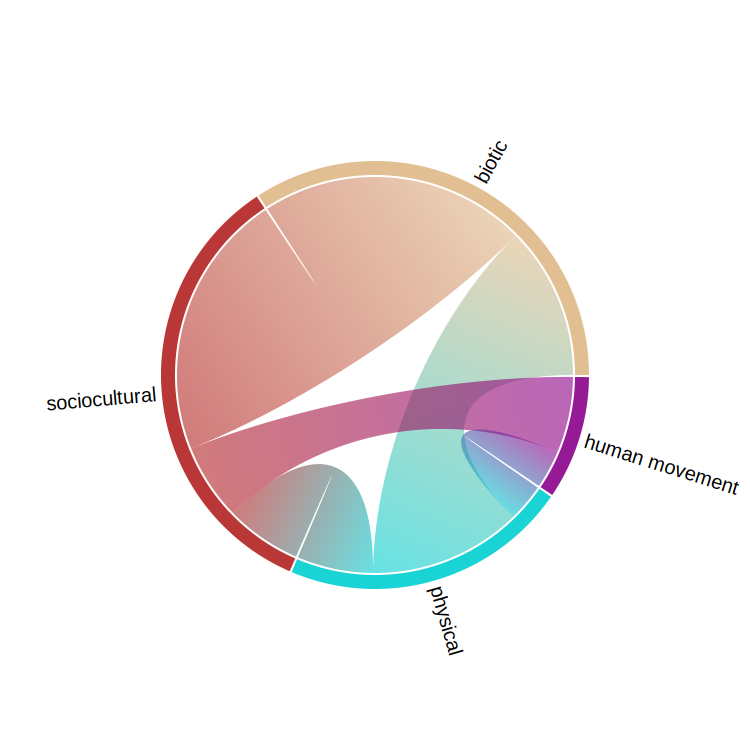

In [3]:
import pandas as pd
import numpy as np
import openchord as ocd

# Load data
file_path = "path"
df = pd.read_csv(file_path)

# Clean and standardize flow type column
df_filtered = df[['DOI', 'X2.1.Flow.Type']].copy()
df_filtered['2.1.Flow.Type'] = df_filtered['X2.1.Flow.Type'].astype(str).str.lower().str.strip()

# Sort
flow_type_order = ['biotic', 'sociocultural', 'physical', 'human movement', 'trade']
df_filtered['Flow Order'] = df_filtered['2.1.Flow.Type'].map(lambda x: flow_type_order.index(x) if x in flow_type_order else len(flow_type_order))
df_filtered = df_filtered.sort_values(by=['Flow Order'])

# Build cross-type connections within each paper
connections = []
for doi, group in df_filtered.groupby('DOI'):
    unique_flows = list(group['2.1.Flow.Type'].unique())
    if len(unique_flows) < 2:
        continue
    for i in range(len(unique_flows)):
        for j in range(i + 1, len(unique_flows)):
            connections.append((unique_flows[i], unique_flows[j]))

# Count co-occurrences
connections_df = pd.DataFrame(connections, columns=['FlowType1', 'FlowType2'])
connections_df = connections_df.groupby(['FlowType1', 'FlowType2']).size().reset_index(name='Weight')

# Filter and sort
active_flows = set(connections_df['FlowType1']).union(set(connections_df['FlowType2']))
sorted_flows = [flow for flow in flow_type_order if flow in active_flows]

# Create adjacency matrix
flow_index = {flow: idx for idx, flow in enumerate(sorted_flows)}
matrix_size = len(sorted_flows)
adj_matrix = np.zeros((matrix_size, matrix_size))

for _, row in connections_df.iterrows():
    i, j = flow_index[row['FlowType1']], flow_index[row['FlowType2']]
    adj_matrix[i, j] += row['Weight']
    adj_matrix[j, i] += row['Weight']

# custom colors
flow_type_colors = {
    'biotic': "#DEB887",       
    'sociocultural': "#B22222",
    'physical': "#00CED1",
    'human movement': "#8B008B",
    'trade': "#ffed6f"
}
flow_colors = [flow_type_colors[flow] for flow in sorted_flows]

# Generate and style chord diagram
fig = ocd.Chord(adj_matrix, sorted_flows)
fig.figsize = (15, 15)
fig.padding = 175
fig.label_distance = 2.0
fig.font_size = 20
fig.font_rotation = 90
fig.colormap = flow_colors
fig.label_orientation = "horizontal"

fig.save_svg("path")
fig.save_png("path")
fig.show()
